# Simple HHL Example

This notebook demonstrates how to use the HHL quantum linear solver to solve a simple linear system of equations.

## Problem: Solve Ax = b

We'll solve a 2×2 system where:
- A is a Hermitian matrix
- b is the right-hand side vector
- x is the solution we want to find

## Step 1: Import Required Libraries

In [1]:
import sys
from pathlib import Path

# Add src directory to Python path
project_root = Path().resolve().parent
src_path = project_root / 'src'
sys.path.insert(0, str(src_path))

import numpy as np
from QLS.hhl import HHL
from QLS.numpy_linear_solver import NumPyLinearSolver
from QLS.gpu_utils import create_gpu_backend

print("✓ Imports successful")


✓ Imports successful


In [2]:
# Handle GPU backend creation with fallback for version compatibility issues
try:
    backend, use_gpu = create_gpu_backend(verbose=True)
    print(f"\nUsing GPU: {use_gpu}")
except ImportError as e:
    print("⚠ GPU backend creation failed due to version compatibility issues.")
    print("  Using StatevectorEstimator (CPU) as fallback...")
    if "To fix this:" in str(e):
        fix_msg = str(e).split("To fix this:")[1]
        print(f"\n  To fix:{fix_msg}")
    from qiskit.primitives import StatevectorEstimator
    backend = StatevectorEstimator()
    use_gpu = False
    print("✓ Using CPU backend (StatevectorEstimator)")

✓ GPU backend successfully initialized and tested!

Backend Configuration:
  Backend name: aer_simulator_statevector_gpu
  Available devices: ['GPU']
  Actually using GPU: True
  Method: statevector
  Precision: double

Using GPU: True


## Step 2: Define the Linear System

We'll create a simple 2×2 Hermitian matrix A and vector b.

In [3]:
# Create a 2×2 Hermitian matrix
A = np.array([
    [1.0, 0.5],
    [0.5, 1.0]
], dtype=complex)

# Right-hand side vector
b = np.array([1.0, 0.0], dtype=complex)

print(f"Matrix A:\n{A}")
print(f"\nVector b: {b}")
print(f"\nMatrix is Hermitian: {np.allclose(A, A.conj().T)}")

Matrix A:
[[1. +0.j 0.5+0.j]
 [0.5+0.j 1. +0.j]]

Vector b: [1.+0.j 0.+0.j]

Matrix is Hermitian: True


## Step 3: Solve Classically (Reference Solution)

In [4]:
# Solve using classical NumPy method
classical_solver = NumPyLinearSolver()
classical_result = classical_solver.solve(A, b)

x_classical = classical_result.state
print(f"Classical solution: {x_classical}")
print(f"Euclidean norm: {classical_result.euclidean_norm:.6f}")

# Verify solution
residual = A @ x_classical - b
print(f"Residual ||Ax - b||: {np.linalg.norm(residual):.2e}")

Classical solution: [ 1.33333333+0.j -0.66666667+0.j]
Euclidean norm: 1.490712
Residual ||Ax - b||: 0.00e+00


## Step 4: Solve Using Quantum HHL Algorithm

In [5]:
# Skip this cell - backend is already created in cell 2 above
# This cell is kept for reference but should be skipped
# If backend wasn't created in cell 2, uncomment the lines below:
# backend, use_gpu = create_gpu_backend(verbose=True)
# print(f"\nUsing GPU: {use_gpu}")

print("ℹ Backend creation handled in cell 2 above")
if 'backend' in locals():
    print(f"✓ Backend already created: {type(backend).__name__}")
    if 'use_gpu' in locals():
        print(f"  Using GPU: {use_gpu}")
else:
    print("⚠ Backend not found. Please run cell 2 first.")


ℹ Backend creation handled in cell 2 above
✓ Backend already created: AerSimulator
  Using GPU: True


In [6]:
# Create HHL solver
# epsilon controls the precision (lower = more accurate but slower)
# HHL can work with Backend (AerSimulator) or StatevectorEstimator
if hasattr(backend, 'run'):
    # It's a Backend (AerSimulator) - use it directly
    hhl = HHL(epsilon=1e-2, quantum_instance=backend)
else:
    # It's a StatevectorEstimator - HHL will use it automatically when quantum_instance is None
    hhl = HHL(epsilon=1e-2, quantum_instance=None)

print("Solving with HHL algorithm...")
quantum_result = hhl.solve(A, b)

# Extract the state vector from the QuantumCircuit
# The solution is encoded in the quantum circuit, we need to extract it
from qiskit.quantum_info import Statevector

# Convert the circuit to a statevector
sv = Statevector(quantum_result.state).data

# For a 2×2 system, the solution is encoded in specific qubits
# The HHL algorithm encodes the solution in the ancilla qubits
# We need to extract the relevant part and scale it
total_qubits = int(np.log2(len(sv)))
base_index = 1 << (total_qubits - 1)  # Start index for solution encoding
dim = len(b)  # Dimension of the problem

# Extract the solution vector
x_quantum_raw = np.array([sv[base_index + i] for i in range(dim)])

# Scale to match the euclidean norm
x_quantum = quantum_result.euclidean_norm * x_quantum_raw / np.linalg.norm(x_quantum_raw)

print(f"\nQuantum solution: {x_quantum.real}")
print(f"Euclidean norm: {quantum_result.euclidean_norm:.6f}")


Solving with HHL algorithm...

Quantum solution: [ 1.33333333 -0.66666667]
Euclidean norm: 1.490712


## Step 5: Compare Results

In [7]:
# Compare solutions
# Ensure both are numpy arrays for comparison
x_classical_array = np.array(x_classical, dtype=complex)
x_quantum_array = np.array(x_quantum, dtype=complex)

difference = np.linalg.norm(x_classical_array - x_quantum_array)
relative_error = difference / np.linalg.norm(x_classical_array)

print("="*60)
print("COMPARISON")
print("="*60)
print(f"Classical solution: {x_classical_array.real}")
print(f"Quantum solution:  {x_quantum_array.real}")
print(f"\nAbsolute difference: {difference:.6e}")
print(f"Relative error: {relative_error:.6e}")

# Verify quantum solution
residual_quantum = A @ x_quantum_array - b
print(f"\nQuantum residual ||Ax - b||: {np.linalg.norm(residual_quantum):.2e}")


COMPARISON
Classical solution: [ 1.33333333 -0.66666667]
Quantum solution:  [ 1.33333333 -0.66666667]

Absolute difference: 6.812734e-16
Relative error: 4.570121e-16

Quantum residual ||Ax - b||: 6.23e-16


## Step 6: Visualization (Optional)

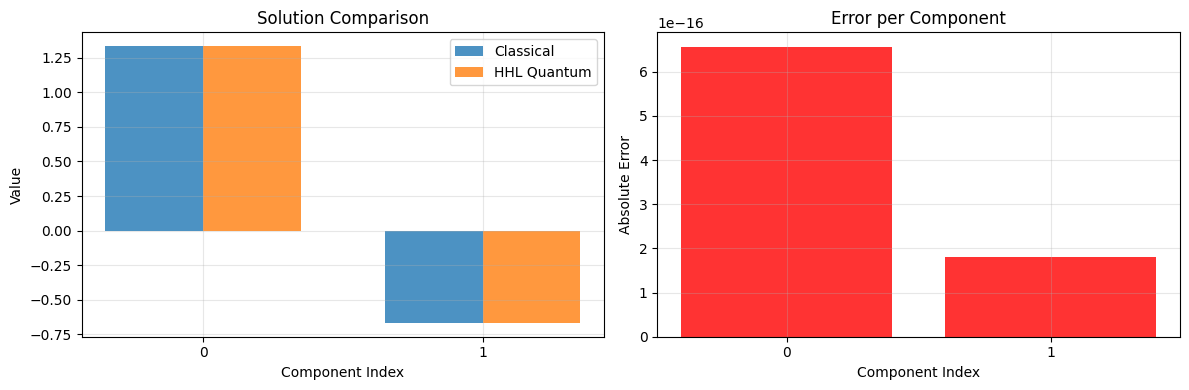

In [8]:
try:
    import matplotlib.pyplot as plt
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot 1: Solution comparison
    x_pos = np.arange(len(x_classical_array))
    width = 0.35
    ax1.bar(x_pos - width/2, x_classical_array.real, width, label='Classical', alpha=0.8)
    ax1.bar(x_pos + width/2, x_quantum_array.real, width, label='HHL Quantum', alpha=0.8)
    ax1.set_xlabel('Component Index')
    ax1.set_ylabel('Value')
    ax1.set_title('Solution Comparison')
    ax1.set_xticks(x_pos)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Error visualization
    error = np.abs(x_classical_array - x_quantum_array)
    ax2.bar(x_pos, error.real, alpha=0.8, color='red')
    ax2.set_xlabel('Component Index')
    ax2.set_ylabel('Absolute Error')
    ax2.set_title('Error per Component')
    ax2.set_xticks(x_pos)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("Matplotlib not available. Install with: pip install matplotlib")


## Summary

This example demonstrated:
1. How to set up a linear system (Ax = b)
2. Solving it classically for reference
3. Solving it using the quantum HHL algorithm
4. Comparing the results

### Key Points:
- The matrix A must be **Hermitian** (A = A†)
- The dimension must be a power of 2 (2, 4, 8, 16, ...)
- The `epsilon` parameter controls precision vs speed trade-off
- GPU acceleration is automatic when available

### Next Steps:
- Try larger matrices (4×4, 8×8)
- Experiment with different epsilon values
- Check out `HHL_Project.py` for linear regression examples